# Pytorch RNNの比較

In [ ]:
# モジュールのインポート
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import urllib.request
import time
import matplotlib.pyplot as plt
import codecs
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
torch.manual_seed(1) 
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
def getstockfromweb():
  page_num = 20 # 取得するページ数
  tstock = []
  for i in range(page_num):
    # Yahoo Financeのページを利用
    url = "https://finance.yahoo.co.jp/quote/998407.O/history?from=20170101&to=20211231&timeFrame=d&page=" + str(i+2)
    html = urllib.request.urlopen(url)
    soup = BeautifulSoup(html, "lxml")
    estock = [value.get_text() for value in soup.find_all("td")[0:100]]
     #<td></td>に欲しい数値が文字で入っているのでその部分を抽出し、get_textで文字のみさらに抽出する
    tstock.extend(estock) # appendではなく一つの大きな配列にするためextendを使う
    time.sleep(0.1) # どんどんデータをとると、サーバが察知してデータが取れなくなる
  tstock = np.array(tstock) # NumPyへ変換
  stock = tstock.reshape(-1, 5)
  stock = pd.DataFrame(stock, columns=['date', 'open', 'max', 'min', 'close'], index=stock[:,0])
  stock = stock.drop('date',axis=1).apply(lambda x: x.str.replace(',','')).apply(lambda x: x.astype(np.float32))
  return stock
  return stock.apply(lambda x: x.str.replace(',','')).astype(np.float32) # 文字を数字に変換

In [ ]:
def getstockdata():
  path = 'stockdata.csv'
  with codecs.open(path, "r", "Shift-JIS", "ignore") as f:
    stock = pd.read_table(f, delimiter=",", header=None, names=['date', 'open', 'max', 'min', 'close', 'total', 'adjustment'])
    stock = stock.drop(stock.index[[0,1]])[['open', 'max', 'min', 'close', 'total', 'adjustment']].apply(lambda x: x.astype(np.float32))
  return stock

In [ ]:
whichdata = False # webスクレイピングを利用する、Falseでダウンロードデータを利用する
if whichdata==True:
  dfp = getstockfromweb()
#  print(dfp.dtypes)
#  print(dfp)
  df = dfp.reset_index(drop=True).drop(columns=['open', 'max', 'min'])
else:
  import os
  if not os.path.exists('stockdata.csv'):
     #!wget "https://drive.google.com/uc?export=download&id=1OsqF2vQ94ZF8gA0IEjhp0rJM-2lnyfUw" -O stockdata.csv 
     !wget "https://keio.box.com/shared/static/xml20yn9im6xiytxe5z25wbja242g61k" -O stockdata.csv
  dfp = getstockdata()
  df = dfp.reset_index(drop=True).drop(columns=['open','max','min','total','adjustment'])

In [ ]:
#訓練データとテストデータに分割
test_size = 0.3
sp = df['close'].values # pandasからnumpyへ変換
total_len = len(sp)
test_len = int(len(sp)*test_size)
train_len = total_len - test_len
train = sp[0:train_len]
test = sp[train_len:total_len]
x_max, x_min = max(sp), min(sp)
train_norm = (train - x_min) / (x_max - x_min)
test_norm = (test - x_min) / (x_max - x_min)

In [ ]:
#時系列データに分割
n_time = 6
x_train, y_train, x_test, y_test= [], [], [], []
for i in range(train_len-n_time):
  x_train.append(train_norm[i:i+n_time].reshape(-1,1)) #0:6 = 0~5までの数
  y_train.append(train_norm[i+n_time]) #6 = 6番目の数
for i in range(test_len-n_time):
  x_test.append(test_norm[i:i+n_time])
  y_test.append(test_norm[i+n_time])

In [ ]:
epochs = 50
batch_size = 32
train_input_data = torch.tensor(x_train, dtype=torch.float)  # テンソルに変換
train_correct_data = torch.tensor(y_train, dtype=torch.float)
train_dataset = torch.utils.data.TensorDataset(train_input_data, train_correct_data)  # trainデータセットの作成
train_loader = DataLoader(train_dataset, batch_size=batch_size)

test_input_data = torch.tensor(x_test, dtype=torch.float)  # テンソルに変換
test_correct_data = torch.tensor(y_test, dtype=torch.float)
test_dataset = torch.utils.data.TensorDataset(test_input_data, test_correct_data)  # testデータセットの作成
test_loader = DataLoader(test_dataset, batch_size=len(x_test))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class GRUN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(GRUN, self).__init__()
    self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    x = x.to(device)
    y_gru, h = self.gru(x, None)
    y = self.fc(y_gru[:, -1, :])
    return y
model_GRUN = GRUN(1, 100, 1).to(device)
#print(model_GRUN)

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    x = x.to(device)
    y_rnn, h = self.rnn(x, None)
    y = self.fc(y_rnn[:, -1, :])
    return y
model_RNN = RNN(1, 100, 1).to(device)
#print(model_RNN)

class LSTMN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTMN, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    x = x.to(device)
    y_lstm, h = self.lstm(x, None)
    y = self.fc(y_lstm[:, -1, :])
    return y
model_LSTMN = LSTMN(1, 100, 1).to(device)
#print(model_LSTMN)

times = [] #時間計測用

In [ ]:
start = time.time() #計測開始
loss_func = nn.MSELoss()
optimizer_GRU = torch.optim.Adam(model_GRUN.parameters(), lr=0.01)
record_loss_train_GRUN = []
for i in range(epochs):
  for j, (x, t) in enumerate(train_loader):
    x, t = x.to(device), t.reshape(-1,1).to(device)
    y = model_GRUN(x)
    loss_GRU = loss_func(y, t)
    optimizer_GRU.zero_grad()
    loss_GRU.backward()
    optimizer_GRU.step()
  loss_GRU /= j+1
  record_loss_train_GRUN.append(loss_GRU.item())

times.append(time.time()-start) #計算時間を記録
#print(f"GRU calculation time:{time.time()-start}")

In [ ]:
start = time.time() #計測開始
loss_func = nn.MSELoss()
optimizer_RNN = torch.optim.Adam(model_RNN.parameters(), lr=0.01)
record_loss_train_RNN = []
for i in range(epochs):
  for j, (x, t) in enumerate(train_loader):
    x, t = x.to(device), t.reshape(-1,1).to(device)
    y = model_RNN(x)
    loss_RNN = loss_func(y, t)
    optimizer_RNN.zero_grad()
    loss_RNN.backward()
    optimizer_RNN.step()
  loss_RNN /= j+1
  record_loss_train_RNN.append(loss_RNN.item())

times.append(time.time()-start) #計算時間を記録
#print(f"RNN calculation time:{time.time()-start}")

In [ ]:
start = time.time() #計測開始
loss_func = nn.MSELoss()
optimizer_LSTMN = torch.optim.Adam(model_LSTMN.parameters(), lr=0.01)
record_loss_train_LSTMN = []
for i in range(epochs):
  for j, (x, t) in enumerate(train_loader):
    x, t = x.to(device), t.reshape(-1,1).to(device)
    y = model_LSTMN(x)
    loss_LSTMN = loss_func(y, t)
    optimizer_LSTMN.zero_grad()
    loss_LSTMN.backward()
    optimizer_LSTMN.step()
  loss_LSTMN /= j+1
  record_loss_train_LSTMN.append(loss_LSTMN.item())

times.append(time.time()-start) #計算時間を記録
#print(f"LSTM calculation time:{time.time()-start}")

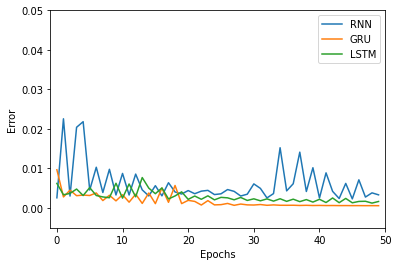

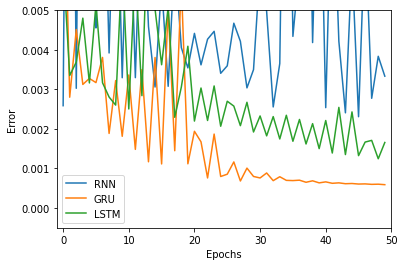

GRU calculation time:0.5524334907531738
RNN calculation time:0.4173574447631836
LSTM calculation time:0.43135786056518555


In [ ]:
# 比較用Loss曲線
plt.plot(range(len(record_loss_train_RNN)),record_loss_train_RNN, label="RNN")
plt.plot(range(len(record_loss_train_GRUN)),record_loss_train_GRUN, label="GRU")
plt.plot(range(len(record_loss_train_LSTMN)),record_loss_train_LSTMN, label="LSTM")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.xlim(-1, 50)
plt.ylim(-0.005,0.05)
plt.show()

# 比較用Loss曲線（拡大）
plt.plot(range(len(record_loss_train_RNN)),record_loss_train_RNN, label="RNN")
plt.plot(range(len(record_loss_train_GRUN)),record_loss_train_GRUN, label="GRU")
plt.plot(range(len(record_loss_train_LSTMN)),record_loss_train_LSTMN, label="LSTM")
plt.xlim(-1, 50)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.ylim(-0.0005,0.005)
plt.show()

# 計算時間の記録
print(f"GRU calculation time:{times[0]}")
print(f"RNN calculation time:{times[1]}")
print(f"LSTM calculation time:{times[2]}")

# 考察
・上記グラフを確認するとRNNとGRU,LSTMの間には大きな違いがあることがわかる。RNNはEpoch数に対してLossの大きさが小さくなる速度は速いものの最終的な値もほかの二つの計算方法と比較してRNNが0.003以上なのに対し、GRU,LSTMは約0.001程度と大きな乖離があった。


・拡大したグラフを利用してGRUとLSTMを比較するとGRUのほうがEpoch数20あたりでLossの最小値を迎え、そのあと大きく上昇していることから過学習となってしまっている。一方LSTMはEpoch数に従って徐々にLossが下がっている様子が読み取れ、Epoch数50当たりでもまだ現象していく兆候が見られることから、さらにEpoch数を増やせばLossの最小値はGRUよりも小さくなる可能性は見られた。

・計算時間も産出したが、いずれも0.40秒前後と大きな違いはなかった。

・3つの計算方法を比較し、今回の題材においてはEpoch数を少なく、かつLossも小さくすることができるGRUが最も適していると考えられる。

# 発展的課題

In [ ]:
epochs = 50
batch_size = 32
x_train = torch.tensor(x_train, dtype=torch.float).reshape(102,-1)  # テンソルに変換
y_train = torch.tensor(y_train, dtype=torch.float)
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)  # trainデータセットの作成
train_loader = DataLoader(train_dataset, batch_size=batch_size)

x_test = torch.tensor(x_test, dtype=torch.float)  # テンソルに変換
y_test = torch.tensor(y_test, dtype=torch.float)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)  # testデータセットの作成
test_loader = DataLoader(test_dataset, batch_size=len(x_test))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(x_train.shape)

cuda:0
torch.Size([102, 6])


In [ ]:
class Net(nn.Module): 
  def __init__(self): 
    super(Net, self).__init__() 
    self.fc1 = nn.Linear(6, 128)
    self.fc2 = nn.Linear(128, 1024) 
    self.fc3 = nn.Linear(1024, 2) 
  def forward(self, x): 
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x) 
    return x 
  
model = Net()

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(500):
  total_loss = 0 
  for x_train, y_train in train_loader: 
    optimizer.zero_grad() 
    output = model(x_train) 
    loss = criterion(output,y_train.long())
    loss.backward() 
    optimizer.step() 
    total_loss += loss.data 
  if(epoch+1)%100 == 0: 
      print(epoch+1, total_loss)


100 tensor(0.4445)
200 tensor(0.3230)
300 tensor(0.2900)
400 tensor(0.2764)
500 tensor(0.2694)


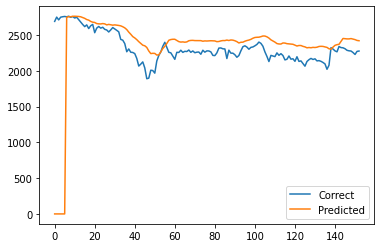

In [ ]:
sp_norm = sp/x_max
in_true = list(sp_norm.reshape(-1).astype(np.float32)) 
pred = []
model.eval()
for i in range(n_time):
  pred.append(0)
with torch.no_grad():
    for i in range(len(sp)-n_time):
      x = torch.tensor(in_true[i:i+n_time])  
      y = model(x)
      pred.append(torch.max(y,0)[0])  
      
plt.plot(range(len(sp)), sp, label="Correct")
pred = np.array(pred)
p_max, p_min = max(pred), min(pred)
p_norm = (pred - p_min) / (p_max - p_min)
pred = p_norm * x_max
plt.plot(range(len(pred)), pred, label="Predicted")
plt.legend()
plt.show()

# 考察
上図からわかるようにRNNやGRU,LSTMと予測結果と実際の値に大きな違いが生まれてしまった。しかしながら、部分的な特徴は抑えてはいるため、ある程度の予測はできていると考えられる。